# the goal is to predict individual's fail rate before their first assessment

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, make_scorer, accuracy_score, precision_score, recall_score
from sklearn.svm import SVC
from scipy import stats
import math
from tqdm import tqdm_notebook
import re
from helpers import preprocessing, TemporalSegments, my_pipeline, time_invariant_features, effort_features, temporal_features, temporal_summary_features
from helpers import temporal_feature_name
from sklearn.base import BaseEstimator, TransformerMixin
%matplotlib inline

In [2]:
# load data
assessments = pd.read_csv('../Data/Raw/assessments.csv') # pk = code_module, code_presentation, id_assessment
courses = pd.read_csv('../Data/Raw/courses.csv') # pk = code_module, code_presentation
studentAssessment = pd.read_csv('../Data/Raw/studentAssessment.csv') # pk = id_assessment(this is unique across course sessions), id_student
studentInfo = pd.read_csv('../Data/Raw/studentInfo.csv') # pk = code_module, code_presentation, id_student
studentRegistration = pd.read_csv('../Data/Raw/studentRegistration.csv') #pk = code_module, code_presentation, id_student
vle = pd.read_csv('../Data/Raw/vle.csv') # pk = id_site
studentVle = pd.read_csv('../Data/Raw/studentVle.csv') # pk = code_module, code_presentation, id_student, id_site

In [5]:
# find out the first assessment date
first_assessement = assessments.groupby(['code_module', 'code_presentation'])['date'].agg('min').reset_index()
first_assessement.columns = ['code_module', 'code_presentation', 'first_assessment_date']

In [6]:
studentVle = studentVle.merge(first_assessement, on=['code_module', 'code_presentation'], how='left')
studentVle['before_first_assessment'] = studentVle['date'] < studentVle['first_assessment_date']
studentVle = studentVle[studentVle['before_first_assessment']]
studentVle.drop(['first_assessment_date', 'before_first_assessment'], axis=1, inplace=True)

In [7]:
class NameSpace(object):
    pass

total = NameSpace()
datasets = [assessments, courses, studentAssessment, studentInfo, 
            studentRegistration, vle, studentVle]
data_names = ['assessments', 'courses', 'studentAssessment', 'studentInfo',
             'studentRegistration', 'vle', 'studentVle']
for pt in range(len(datasets)):
    name = data_names[pt]
    df = datasets[pt]
    setattr(total, name, df)

In [8]:
total_data = preprocessing.fit_transform(total)

the result of merging for studentVle and vle is 
 both          2460994
right_only       2321
left_only           0
Name: _merge, dtype: int64
the result of merging for studentInfo+assessments and engagement is 
 both          43291
left_only       753
right_only        0
Name: _merge, dtype: int64


In [9]:
# exclude temporal_segments > 1
# temporal_segment = 1 is the first 30 days from course start
total_data = total_data[total_data['temperal_seg'] <=1]

In [10]:
# include extra registration features
registration = total.studentRegistration.drop('date_unregistration', axis=1)
total_data = total_data.merge(registration, 
                              on=['code_module', 'code_presentation', 'id_student'], 
                              how='left', indicator=True)

In [11]:
# nicely merged!
print(total_data['_merge'].value_counts())
total_data.drop('_merge', inplace=True, axis=1)

both          39708
right_only        0
left_only         0
Name: _merge, dtype: int64


In [12]:
training_presentation = ['2013B', '2013J', '2014B']
testing_presentation = ['2014J']

In [13]:
train = total_data[total_data['code_presentation'].isin(training_presentation)]
test = total_data[total_data['code_presentation'].isin(testing_presentation)]

In [14]:
X_train, y_train = TemporalSegments(train).get_temporal_segment(1)
X_test, y_test = TemporalSegments(test).get_temporal_segment(1)

In [15]:
class myPCA(TransformerMixin):
    def fit(self, X, y=None):
        effort_features = temporal_feature_name('effort_features', 1)
        resource_features = temporal_feature_name('resource_features', 1)
        temporal_features = temporal_feature_name('temporal_features', 1)
        temporal_summary_features = temporal_feature_name('temporal_summary_features', 1)
        X_resource = X[resource_features]
        X_temporal = X[temporal_features]
        
        resource_pca_num = 4
        temporal_pca_num = 20
        self.resource_pca = PCA(resource_pca_num)
        self.temporal_pca = PCA(temporal_pca_num)
        self.resource_pca.fit(X_resource)
        self.temporal_pca.fit(X_temporal)
        self.resouce_pca_cols = ['rescourse_pca' + str(i) for i in range(1, resource_pca_num + 1)]
        self.temporal_pca_cols = ['click_date_pca' + str(i) for i in range(1, temporal_pca_num + 1)]
        self.feature_names = time_invariant_features + effort_features + temporal_summary_features + \
            self.resouce_pca_cols + self.temporal_pca_cols
        return self
    
    def transform(self, X, y=None):
        resource_features = temporal_feature_name('resource_features', 1)
        temporal_features = temporal_feature_name('temporal_features', 1)
        X_resource = X[resource_features]
        X_temporal = X[temporal_features]
        
        X = X.drop(resource_features + temporal_features, axis=1)
        resource_pca_df = pd.DataFrame(self.resource_pca.transform(X_resource), index=X.index, columns=self.resouce_pca_cols)
        temporal_pca_df = pd.DataFrame(self.temporal_pca.transform(X_temporal), index=X.index, columns=self.temporal_pca_cols)
        
        X = pd.concat([X, resource_pca_df, temporal_pca_df], axis=1)
        return X
#     def fit_transform(self, X, y=None):
#         pass

In [16]:
pipe = Pipeline([('pca', myPCA()), ('imp', Imputer())])

# GridSearch for three classifiers: 
1. RandomForest
2. Gradient Boosted Trees
3. SVM

In [17]:
pipe.fit(X_train, y_train)
X_train_clean = pipe.transform(X_train)
X_test_clean = pipe.transform(X_test)

In [18]:
f1_scorer = make_scorer(f1_score)
cv = KFold(5) # concerning the fitting speed, ideally this should be 20, at least

In [19]:
# random forest
forest = RandomForestClassifier(min_samples_split=10, min_samples_leaf=10, class_weight='balanced')
forest_parameters = {'n_estimators': (100, 200), 'max_depth': (10, 30)}
forest_clf = GridSearchCV(forest, forest_parameters, f1_scorer, cv=cv)

In [20]:
boosted = GradientBoostingClassifier(min_samples_split=10, min_samples_leaf=10)
boosted_parameters = {'n_estimators': (100, 200), 'max_depth': (10, 30)}
boosted_clf = GridSearchCV(boosted, boosted_parameters, f1_scorer, cv=cv)

In [21]:
svm = SVC(class_weight='balanced', kernel='poly')
svm_parameters = {'C': [1, 10], 'degree': (3, 5)}
svm_clf = GridSearchCV(svm, svm_parameters, f1_scorer, cv=cv)

In [22]:
#[forest_clf, boosted_clf, svm_clf]
for clf in tqdm_notebook([forest_clf, boosted_clf], desc='fitting classifiers'):
    clf.fit(X_train_clean, y_train)

A Jupyter Widget

In [24]:
best_score = 0
best_estimator = None
for clf in [forest_clf, boosted_clf]:
    if clf.best_score_ > best_score:
        best_score = clf.best_score_
        best_estimator = clf.best_estimator_

best_forest = forest_clf.best_estimator_
best_boost = boosted_clf.best_estimator_

# Check the Important Features in RandomForest and BoostedTrees

In [32]:
best_boost.fit(X_train_clean, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [25]:
best_forest.fit(X_train_clean, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [34]:
def feature_importance(scores):
    effort_features = temporal_feature_name('effort_features', 1)
    resource_features = temporal_feature_name('resource_features', 1)
    temporal_features = temporal_feature_name('temporal_features', 1)
    temporal_summary_features = temporal_feature_name('temporal_summary_features', 1)
    resource_pca_num = 4
    temporal_pca_num = 20
    resouce_pca_cols = ['rescourse_pca' + str(i) for i in range(1, resource_pca_num + 1)]
    temporal_pca_cols = ['click_date_pca' + str(i) for i in range(1, temporal_pca_num + 1)]
    features = time_invariant_features + effort_features + temporal_summary_features + \
                resouce_pca_cols + temporal_pca_cols
        
    return pd.DataFrame({'feature': features, 'importance': scores}
                       ).sort_values('importance', ascending=False)

In [35]:
best_forest_top_features = feature_importance(best_forest.feature_importances_).head(10)
best_boosted_top_features = feature_importance(best_boost.feature_importances_).head(10)

In [36]:
print('the top features for the random forest is :\n')
print(best_forest_top_features)
print('the top features for the gradient boosted trees is :\n')
print(best_boosted_top_features)

the top features for the random forest is :

               feature  importance
28             t1_peak    0.088633
27        t1_sum_click    0.067428
26   date_registration    0.067098
31    t1_longest_zeros    0.059211
29        t1_variation    0.042812
19  Lower Than A Level    0.039765
24            imd_band    0.036234
34      rescourse_pca2    0.031758
36      rescourse_pca4    0.026837
33      rescourse_pca1    0.026741
the top features for the gradient boosted trees is :

              feature  importance
36     rescourse_pca4    0.042919
33     rescourse_pca1    0.040346
28            t1_peak    0.038741
26  date_registration    0.038726
32    t1_longest_ones    0.037712
55   click_date_pca19    0.035927
35     rescourse_pca3    0.033646
46   click_date_pca10    0.033023
34     rescourse_pca2    0.032908
39    click_date_pca3    0.032831


# Evaluate the performance of model on testing data

In [37]:
# precision, recall, f1, auc
predict = best_estimator.predict(X_test_clean)
precision = precision_score(y_test, predict)
recall = recall_score(y_test, predict)
f1 = f1_score(y_test, predict)
predict_ba = best_estimator.predict_proba(X_test_clean)[:, 1]
auc = roc_auc_score(y_test, predict_ba)

In [38]:
print('the precision of best model is {}'.format(precision))
print('the recall of best model is {}'.format(recall))
print('the f1 score of the best model is {}'.format(f1))
print('the area under curve of the best model is {}'.format(auc))

the precision of best model is 0.3901827302042279
the recall of best model is 0.6090604026845637
the f1 score of the best model is 0.4756497051758026
the area under curve of the best model is 0.7052288431076329


In [39]:
# roc 
fpr, tpr, _ = roc_curve(y_test, predict_ba)

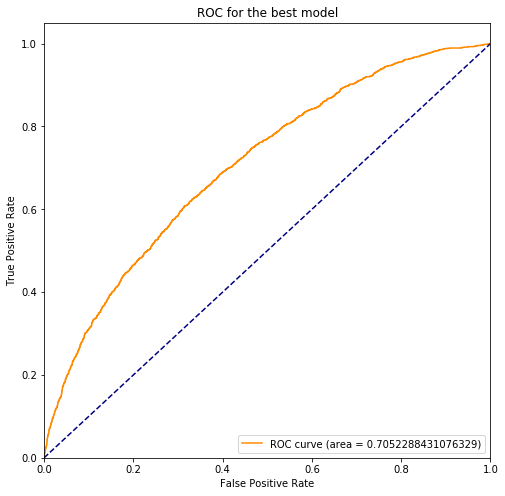

In [41]:
fig = plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = {})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for the best model')
plt.legend(loc="lower right")

# Descide the best threshold

In [48]:
def best_threshold(y_true, proba, scoring='f1_score', step = 0.01):
    if scoring == 'f1_score':
        scoring_func = f1_score
    else:
        raise NotImplementedError
    
    # exclusively go through all
    thresholds = []
    scores = []
    threshold = 0
    
    while threshold <= 0.99:
        y_predict = (proba > threshold)
        curr_score = scoring_func(y_true, y_predict)
        
        thresholds.append(threshold)
        scores.append(curr_score)
        threshold += step
    return thresholds, scores

In [49]:
thresholds, scores = best_threshold(y_test, predict_ba)
best_score = max(scores)
index = scores.index(best_score)
best_threshold = thresholds[index]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


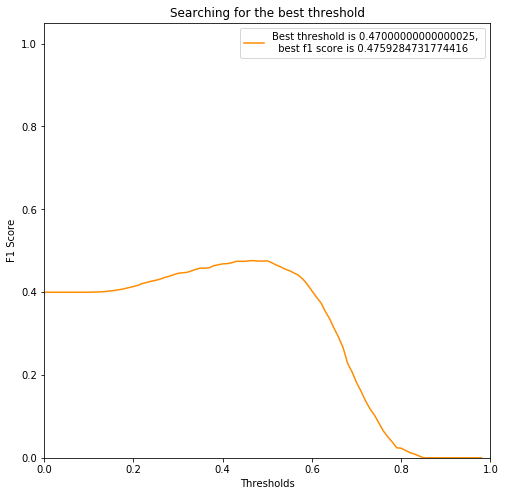

In [53]:
# visualize the threshold and scores
fig = plt.figure(figsize=(8, 8))
plt.plot(thresholds, scores, color='darkorange', 
         label='Best threshold is {}, \n  best f1 score is {}'.format(best_threshold, best_score))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Thresholds')
plt.ylabel('F1 Score')
plt.title('Searching for the best threshold')
plt.legend()